# Download library

In [ ]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.2 MB/s eta 0:00:00


In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 3.0 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-f7p9ld_h
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-f7p9ld_h
  Resolved https://github.com/huggingface/accelerate to commit b30a349078d5301411e8af421720eaa60e984fa2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.22.0.dev0-py3-none-any.whl size=250102 sha256=fc9c61628b7a5f301208dea357b07955642b9387d6f10265e524974ee6a7f63b
  Stored in directory: /tmp/pip-ephem-wheel-cache-fe3u5ib4/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.21.0
    Uninstalling accelerate-0.21.0:
      Successfully uninstalled accelerate-0.21.0


In [ ]:
# !pip install huggingface_hub

# Load data and pre-processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

In [ ]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
df_p = pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/all_P.csv")
df_r = pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/all_R.csv")

R_4_attack=pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/R_4_attack.csv.csv")
R_2_attack=pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/R_2_attack.csv")
R_1_attack=pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/R_1_attack.csv")

#P
P_3_attack=pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/P_3_attack.csv")
P_1_attack=pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/P_1_attack.csv")
P_perception_attack=pd.read_csv('/content/drive/MyDrive/thesis_project_files/main_label/P_perception_attack.csv')


In [ ]:
df_p = df_p.drop(['Duration', 'comment', 'Role','combine'], axis=1)
df_r = df_r.drop(['Duration', 'comment', 'Role','combine'], axis=1)

In [ ]:
df_r = df_r.rename(columns={"Label":"label", "clean_text":"text"})
df_p = df_p.rename(columns={"Label":"label", "clean_text":"text"})

In [ ]:
R_4_attack=R_4_attack.drop(['Unnamed: 0'],axis=1)
R_2_attack=R_2_attack.drop(['Unnamed: 0'],axis=1)
R_1_attack=R_1_attack.drop(['Unnamed: 0'],axis=1)

P_3_attack=P_3_attack.drop(['Unnamed: 0'],axis=1)
P_1_attack=P_1_attack.drop(['Unnamed: 0'],axis=1)
P_perception_attack=P_perception_attack.drop(['Unnamed: 0'],axis=1)

In [ ]:
P_labels=['information','design action', 'failure action','failure reasoning', 'perception']
R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']

In [ ]:
def exclude(df, labels):
  exclude_idx=[]
  for d in range(0, len(df['label'])):
    if df['label'][d] not in labels:
      exclude_idx.append(d)
  return df.drop(index=(exclude_idx))


df_r=exclude(df_r, R_labels)
df_p=exclude(df_p, P_labels)

In [ ]:
df_r_train=pd.concat([R_4_attack,R_2_attack,R_1_attack])
df_p_train=pd.concat([P_3_attack,P_1_attack,P_perception_attack])

In [ ]:
#P_labels=['information','design action', 'failure action','failure reasoning', 'perception']

def convert_p(label):
  label=str(label)
  if label=='information':
      return 0
  elif label=='design action':
      return 1
  elif label=='failure action':
      return 2
  elif label=='failure reasoning':
      return 3
  else:
      return 4

df_p['index']=df_p['label'].apply(convert_p)
df_p_train['index']=df_p_train['label'].apply(convert_p)

In [ ]:
#R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']

def convert(label):
  label=str(label)
  if label=='introduction':
      return 0
  elif label=='clarification':
      return 1
  elif label=='workshop management':
      return 2
  elif label=='implementation':
      return 3
  else:
      return 4

df_r['index']=df_r['label'].apply(convert)
df_r_train['index']=df_r_train['label'].apply(convert)

In [ ]:
df_r_train.groupby(['label']).size()

label
clarification     605
failure           786
implementation    691
introduction      723
dtype: int64

In [ ]:
df_p_train.groupby(['label']).size()

label
failure action    390
information       240
perception        359
dtype: int64

# Model

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
class MainDataset(Dataset):

    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(text,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              pad_to_max_length=True,
                                              return_attention_mask=True,
                                              return_tensors='pt',
                                              truncation = True
                                             )
        return {'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MainDataset(
    text=df['text'].to_numpy(),
    targets=df['index'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [ ]:
class Classifier(nn.Module):

  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask,return_dict=False):
    _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask, return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
class Train_Model:

  def __init__(self, model, loss_fn, optimizer, device, scheduler, n_examples):
    self.model=model
    self.loss_fn=loss_fn
    self.optimizer=optimizer
    self.device=device
    self.scheduler=scheduler
    self.n_examples=n_examples

  def train_epoch(self, train_data_loader):
    model = self.model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(train_data_loader):
      input_ids = d["input_ids"].to(self.device)
      attention_mask = d["attention_mask"].to(self.device)
      targets = d["targets"].to(self.device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask, return_dict=False
      )

      _, preds = torch.max(outputs, dim=1)
      loss = self.loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      self.optimizer.step()
      self.scheduler.step()
      self.optimizer.zero_grad()

    return correct_predictions.double() / self.n_examples, np.mean(losses)

  def eval_model(self, val_data_loader):
      model = self.model.eval()

      losses = []
      correct_predictions = 0

      with torch.no_grad():
        for d in tqdm(val_data_loader):
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,return_dict=False
          )
          _, preds = torch.max(outputs, dim=1)

          loss = self.loss_fn(outputs, targets)

          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())

      return correct_predictions.double() / self.n_examples, np.mean(losses)

  def get_predictions(self, test_data_loader):
      model = self.model.eval()

      texts = []
      predictions = []
      prediction_probs = []
      real_values = []

      with torch.no_grad():
        for d in test_data_loader:

          text = d["text"]
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)

          probs = F.softmax(outputs, dim=1)

          texts.extend(text)
          predictions.extend(preds)
          prediction_probs.extend(probs)
          real_values.extend(targets)

      predictions = torch.stack(predictions).cpu()
      prediction_probs = torch.stack(prediction_probs).cpu()
      real_values = torch.stack(real_values).cpu()
      return texts, predictions, prediction_probs, real_values

# Researcher

In [ ]:
train_r, test_r = train_test_split(df_r, test_size=0.2)
valid_r, test_r = train_test_split(test_r, test_size=0.5)
train_r=pd.concat([train_r, df_r_train])

In [ ]:
train_data_loader_r = create_data_loader(train_r, tokenizer, max_len=128, batch_size=16)
val_data_loader_r = create_data_loader(valid_r, tokenizer, max_len=128, batch_size=16)
test_data_loader_r = create_data_loader(test_r, tokenizer, max_len=128, batch_size=16)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# define parameters
EPOCHS = 20

model = Classifier(len(R_labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader_r) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

R_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train_r))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = R_model_train.train_epoch(train_data_loader_r)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = R_model_train.eval_model(val_data_loader_r)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


  0%|          | 0/290 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.1566703599813426 accuracy 0.6041081081081081


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 5.958632787068685 accuracy 0.013189189189189189

Epoch 2/20
----------


  0%|          | 0/290 [00:00<?, ?it/s]

Train loss 1.1109052078661927 accuracy 0.6685405405405406


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 5.390342823664347 accuracy 0.013189189189189189

Epoch 3/20
----------


  0%|          | 0/290 [00:00<?, ?it/s]

Train loss 1.537429405459813 accuracy 0.5303783783783784


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 3.60135555267334 accuracy 0.013189189189189189

Epoch 4/20
----------


  0%|          | 0/290 [00:00<?, ?it/s]

Train loss 0.9396845893838025 accuracy 0.7145945945945946


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 4.972726694742838 accuracy 0.013189189189189189

Epoch 5/20
----------


  0%|          | 0/290 [00:00<?, ?it/s]

Train loss 0.8831492818771572 accuracy 0.7701621621621622


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 4.771158838272095 accuracy 0.013189189189189189

Epoch 6/20
----------


  0%|          | 0/290 [00:00<?, ?it/s]

Train loss 1.1139980751479142 accuracy 0.6895135135135135


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 4.063027858734131 accuracy 0.013189189189189189

Epoch 7/20
----------


  0%|          | 0/290 [00:00<?, ?it/s]

Train loss 1.1089301768325044 accuracy 0.6804324324324325


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.1578393300374348 accuracy 0.016432432432432434

Epoch 8/20
----------


  0%|          | 0/290 [00:00<?, ?it/s]

Train loss 0.7689750570876138 accuracy 0.7593513513513513


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.5694780270258586 accuracy 0.013837837837837838

Epoch 9/20
----------


  0%|          | 0/290 [00:00<?, ?it/s]

Train loss 0.7260768561302845 accuracy 0.7827027027027027


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.1790315310160318 accuracy 0.020324324324324326

Epoch 10/20
----------


  0%|          | 0/290 [00:00<?, ?it/s]

Train loss 0.5631586638604419 accuracy 0.84


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.4146556933720906 accuracy 0.017297297297297298

Epoch 11/20
----------


  0%|          | 0/290 [00:00<?, ?it/s]

Train loss 0.4698298483664483 accuracy 0.8698378378378379


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.0454967339833576 accuracy 0.024864864864864864

Epoch 12/20
----------


  0%|          | 0/290 [00:00<?, ?it/s]

Train loss 0.3661868603330041 accuracy 0.9027027027027027


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.6837751309076945 accuracy 0.030486486486486487

Epoch 13/20
----------


  0%|          | 0/290 [00:00<?, ?it/s]

Train loss 0.28558235737507165 accuracy 0.9247567567567567


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.5651968280474344 accuracy 0.031135135135135134

Epoch 14/20
----------


  0%|          | 0/290 [00:00<?, ?it/s]

Train loss 0.2118136687636785 accuracy 0.945081081081081


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.4281403223673503 accuracy 0.03437837837837838

Epoch 15/20
----------


  0%|          | 0/290 [00:00<?, ?it/s]

Train loss 0.17500467804684064 accuracy 0.9545945945945946


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.4713367899258931 accuracy 0.03545945945945946

Epoch 16/20
----------


  0%|          | 0/290 [00:00<?, ?it/s]

Train loss 0.14507222524753788 accuracy 0.9608648648648649


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.5248865922292074 accuracy 0.03567567567567567

Epoch 17/20
----------


  0%|          | 0/290 [00:00<?, ?it/s]

Train loss 0.13116747056714115 accuracy 0.9654054054054054


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.5787031372388205 accuracy 0.03567567567567567

Epoch 18/20
----------


  0%|          | 0/290 [00:00<?, ?it/s]

Train loss 0.11905314269784742 accuracy 0.9695135135135136


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.5106556077798208 accuracy 0.036756756756756756

Epoch 19/20
----------


  0%|          | 0/290 [00:00<?, ?it/s]

Train loss 0.08847143357481149 accuracy 0.9768648648648649


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.5771606047948201 accuracy 0.036108108108108106

Epoch 20/20
----------


  0%|          | 0/290 [00:00<?, ?it/s]

Train loss 0.06744245642762037 accuracy 0.9827027027027027


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.5770256678263346 accuracy 0.03632432432432432



In [ ]:
y_texts, y_pred, y_pred_probs, y_test = R_model_train.get_predictions(test_data_loader_r)

In [ ]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.6897865843371461

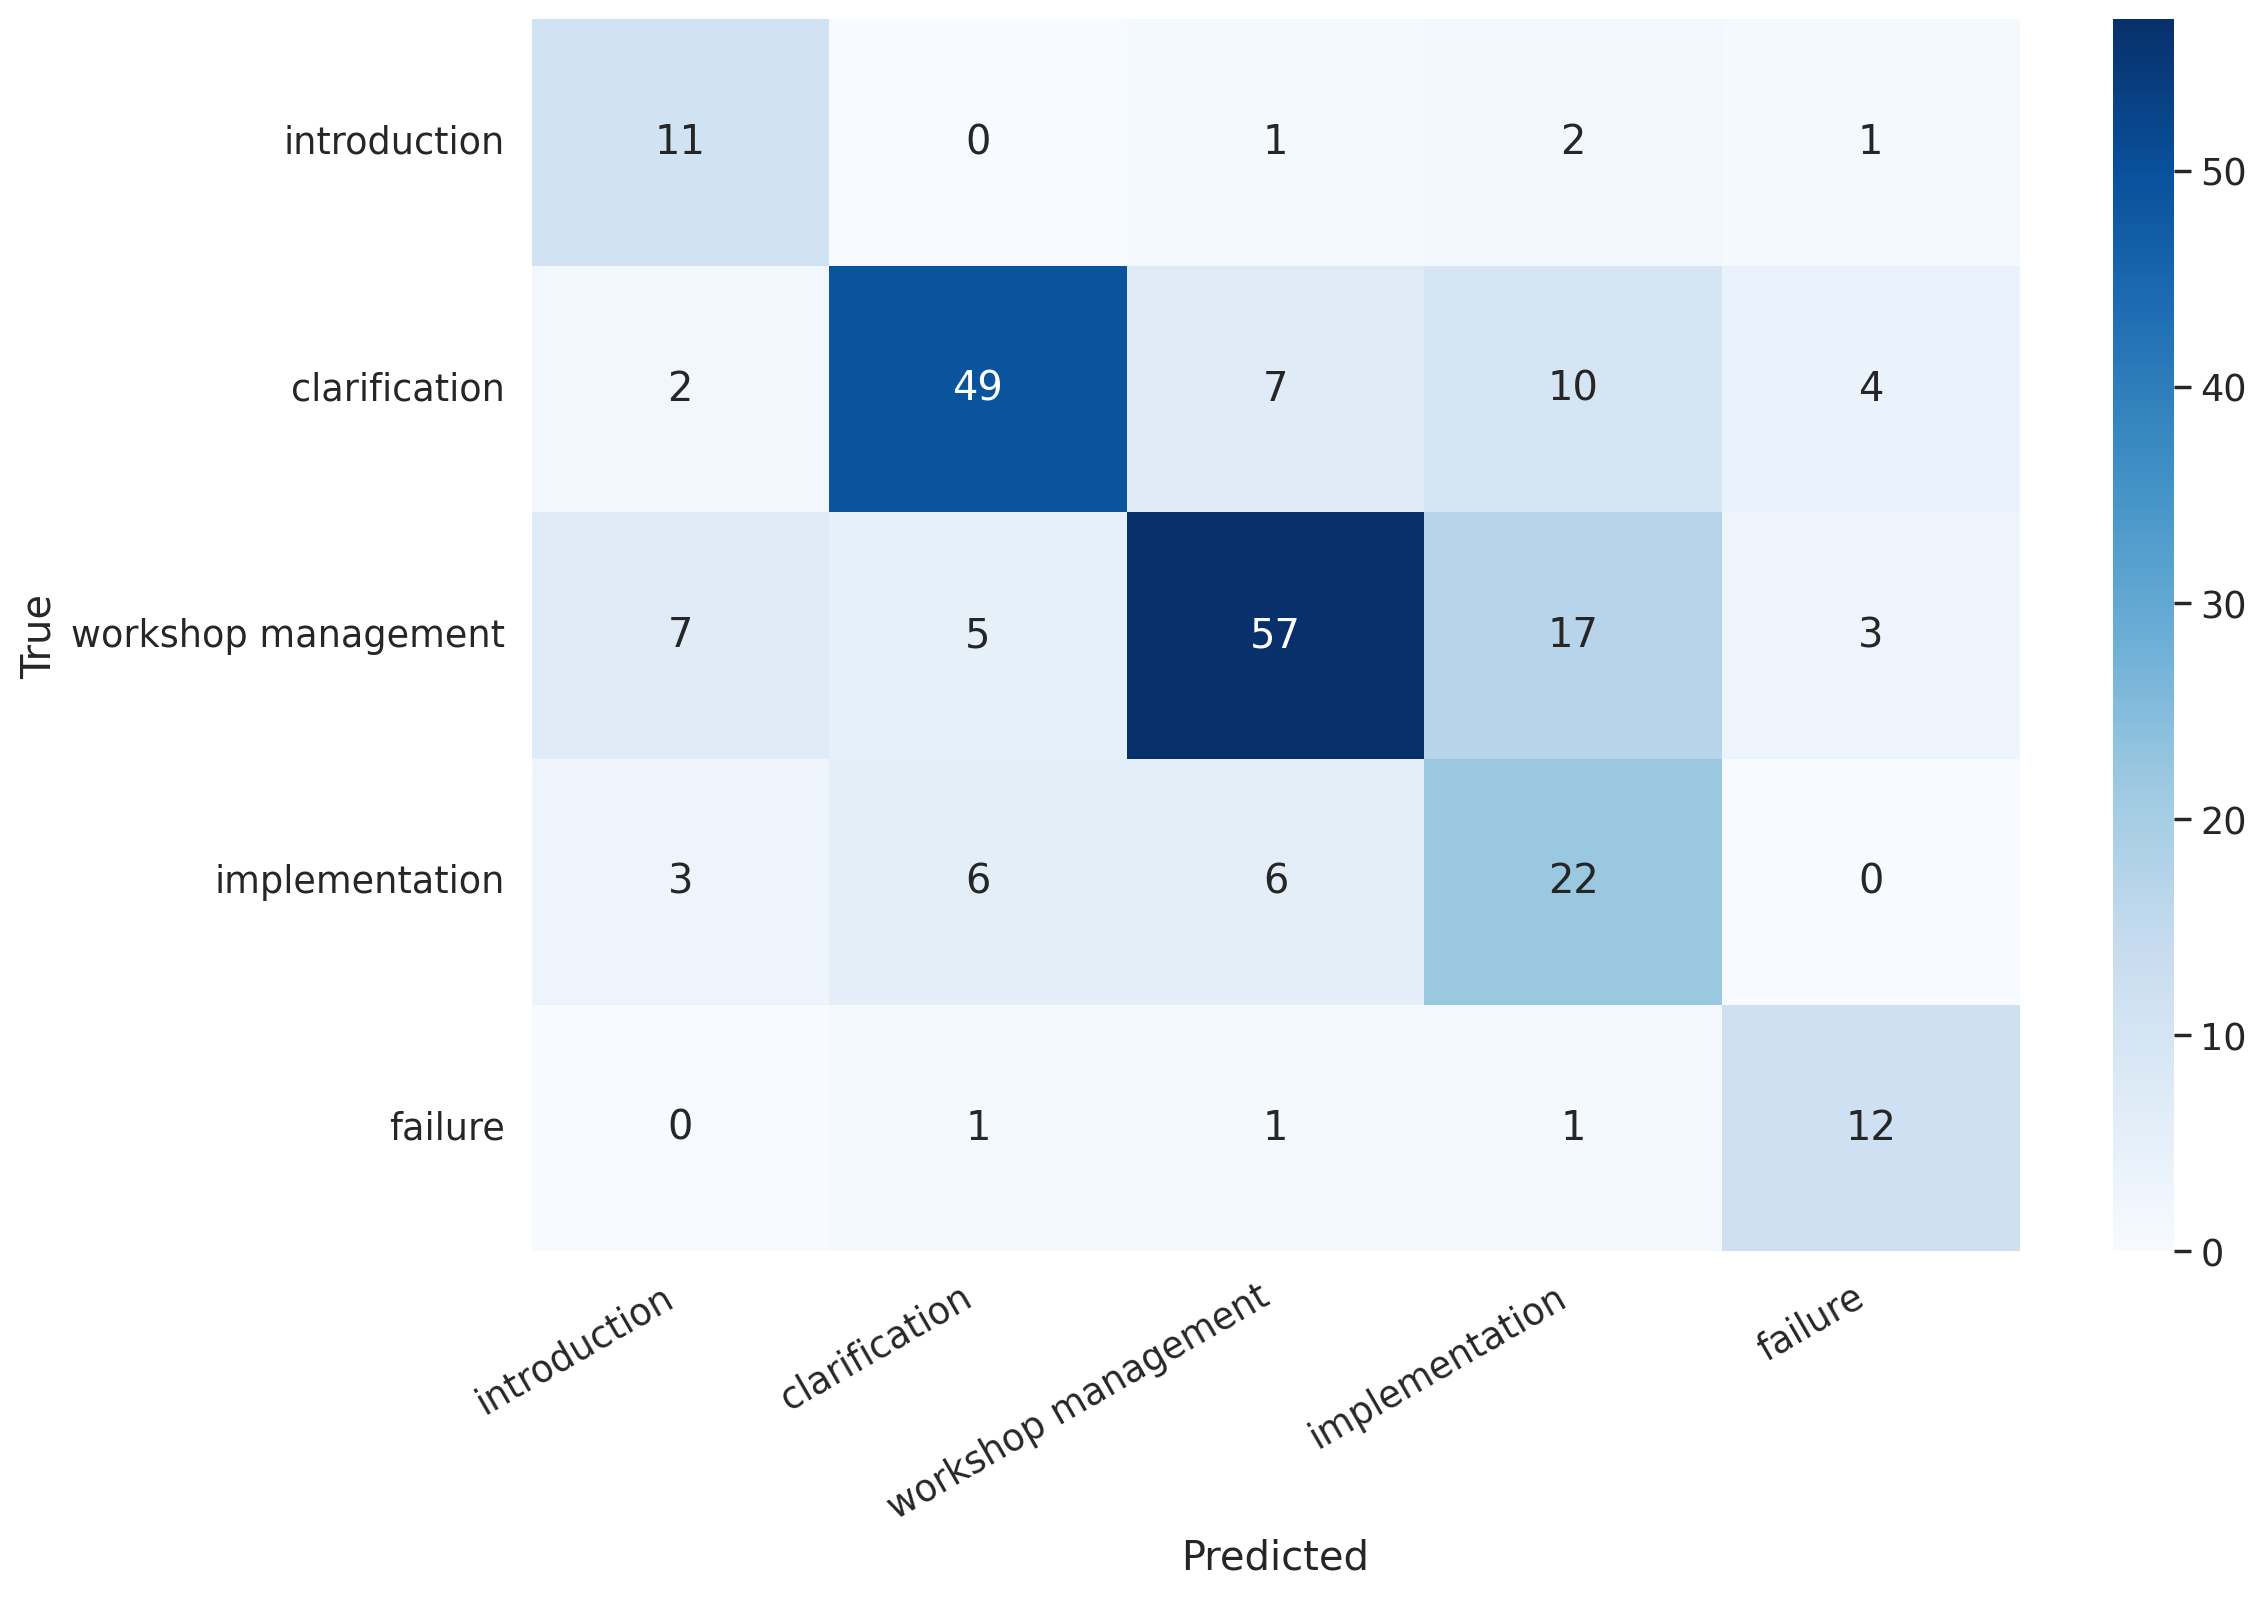

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=R_labels, columns=R_labels)
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(y_test, y_pred, target_names=R_labels))

                     precision    recall  f1-score   support

       introduction       0.48      0.73      0.58        15
      clarification       0.80      0.68      0.74        72
workshop management       0.79      0.64      0.71        89
     implementation       0.42      0.59      0.49        37
            failure       0.60      0.80      0.69        15

           accuracy                           0.66       228
          macro avg       0.62      0.69      0.64       228
       weighted avg       0.70      0.66      0.67       228



# Participant

In [ ]:
train_p, test_p = train_test_split(df_p, test_size=0.2)
valid_p, test_p = train_test_split(test_p, test_size=0.5)
train_p=pd.concat([train_p, df_p_train])

In [ ]:
train_data_loader_p = create_data_loader(train_p, tokenizer, max_len=128, batch_size=16)
val_data_loader_p = create_data_loader(valid_p, tokenizer, max_len=128, batch_size=16)
test_data_loader_p = create_data_loader(test_p, tokenizer, max_len=128, batch_size=16)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# define parameters
EPOCHS = 20

model = Classifier(len(P_labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader_p) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

P_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train_p))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = P_model_train.train_epoch(train_data_loader_p)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = P_model_train.eval_model(val_data_loader_p)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


  0%|          | 0/153 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.4060157259509236 accuracy 0.4102249488752556


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.3822146455446878 accuracy 0.013496932515337423

Epoch 2/20
----------


  0%|          | 0/153 [00:00<?, ?it/s]

Train loss 1.4805197826361443 accuracy 0.3783231083844581


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 5.063747684160869 accuracy 0.013496932515337423

Epoch 3/20
----------


  0%|          | 0/153 [00:00<?, ?it/s]

Train loss 1.5485032619238874 accuracy 0.3803680981595092


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 4.417320291201274 accuracy 0.013496932515337423

Epoch 4/20
----------


  0%|          | 0/153 [00:00<?, ?it/s]

Train loss 1.7916689951435414 accuracy 0.22413087934560327


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.8698786199092865 accuracy 0.013496932515337423

Epoch 5/20
----------


  0%|          | 0/153 [00:00<?, ?it/s]

Train loss 1.7597148122351154 accuracy 0.18732106339468302


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.7513107061386108 accuracy 0.006543967280163599

Epoch 6/20
----------


  0%|          | 0/153 [00:00<?, ?it/s]

Train loss 1.7770143856410108 accuracy 0.16237218813905932


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.6128242214520772 accuracy 0.013496932515337423

Epoch 7/20
----------


  0%|          | 0/153 [00:00<?, ?it/s]

Train loss 1.7362205826379116 accuracy 0.18977505112474438


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.5895054737726848 accuracy 0.013496932515337423

Epoch 8/20
----------


  0%|          | 0/153 [00:00<?, ?it/s]

Train loss 1.7553273431615892 accuracy 0.18691206543967281


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.5734995404879253 accuracy 0.013496932515337423

Epoch 9/20
----------


  0%|          | 0/153 [00:00<?, ?it/s]

Train loss 1.745892670419481 accuracy 0.18773006134969325


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.560800443092982 accuracy 0.013496932515337423

Epoch 10/20
----------


  0%|          | 0/153 [00:00<?, ?it/s]

Train loss 1.7470126518237046 accuracy 0.17995910020449898


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.5524548987547557 accuracy 0.013496932515337423

Epoch 11/20
----------


  0%|          | 0/153 [00:00<?, ?it/s]

Train loss 1.7417001451542176 accuracy 0.19059304703476482


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.5468486150105794 accuracy 0.013496932515337423

Epoch 12/20
----------


  0%|          | 0/153 [00:00<?, ?it/s]

Train loss 1.7524538133658616 accuracy 0.18650306748466258


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.5423746208349864 accuracy 0.013496932515337423

Epoch 13/20
----------


  0%|          | 0/153 [00:00<?, ?it/s]

Train loss 1.731932712536232 accuracy 0.20736196319018405


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.5393599371115367 accuracy 0.013496932515337423

Epoch 14/20
----------


  0%|          | 0/153 [00:00<?, ?it/s]

Train loss 1.725001042185266 accuracy 0.19754601226993865


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.533849557240804 accuracy 0.023721881390593048

Epoch 15/20
----------


  0%|          | 0/153 [00:00<?, ?it/s]

Train loss 1.723173638574438 accuracy 0.19304703476482618


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.52978515625 accuracy 0.023721881390593048

Epoch 16/20
----------


  0%|          | 0/153 [00:00<?, ?it/s]

Train loss 1.7159470008089652 accuracy 0.1901840490797546


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.528019557396571 accuracy 0.023721881390593048

Epoch 17/20
----------


  0%|          | 0/153 [00:00<?, ?it/s]

Train loss 1.7013548043818256 accuracy 0.20572597137014315


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.5242453614870708 accuracy 0.023721881390593048

Epoch 18/20
----------


  0%|          | 0/153 [00:00<?, ?it/s]

Train loss 1.7038350938971525 accuracy 0.2130879345603272


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.5213209887345631 accuracy 0.023721881390593048

Epoch 19/20
----------


  0%|          | 0/153 [00:00<?, ?it/s]

Train loss 1.703630256497003 accuracy 0.2


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.51781099041303 accuracy 0.023721881390593048

Epoch 20/20
----------


  0%|          | 0/153 [00:00<?, ?it/s]

Train loss 1.6969700358272377 accuracy 0.19713701431492842


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.5150535504023235 accuracy 0.023721881390593048



In [ ]:
y_texts, y_pred, y_pred_probs, y_test = P_model_train.get_predictions(test_data_loader_p)

In [ ]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.2

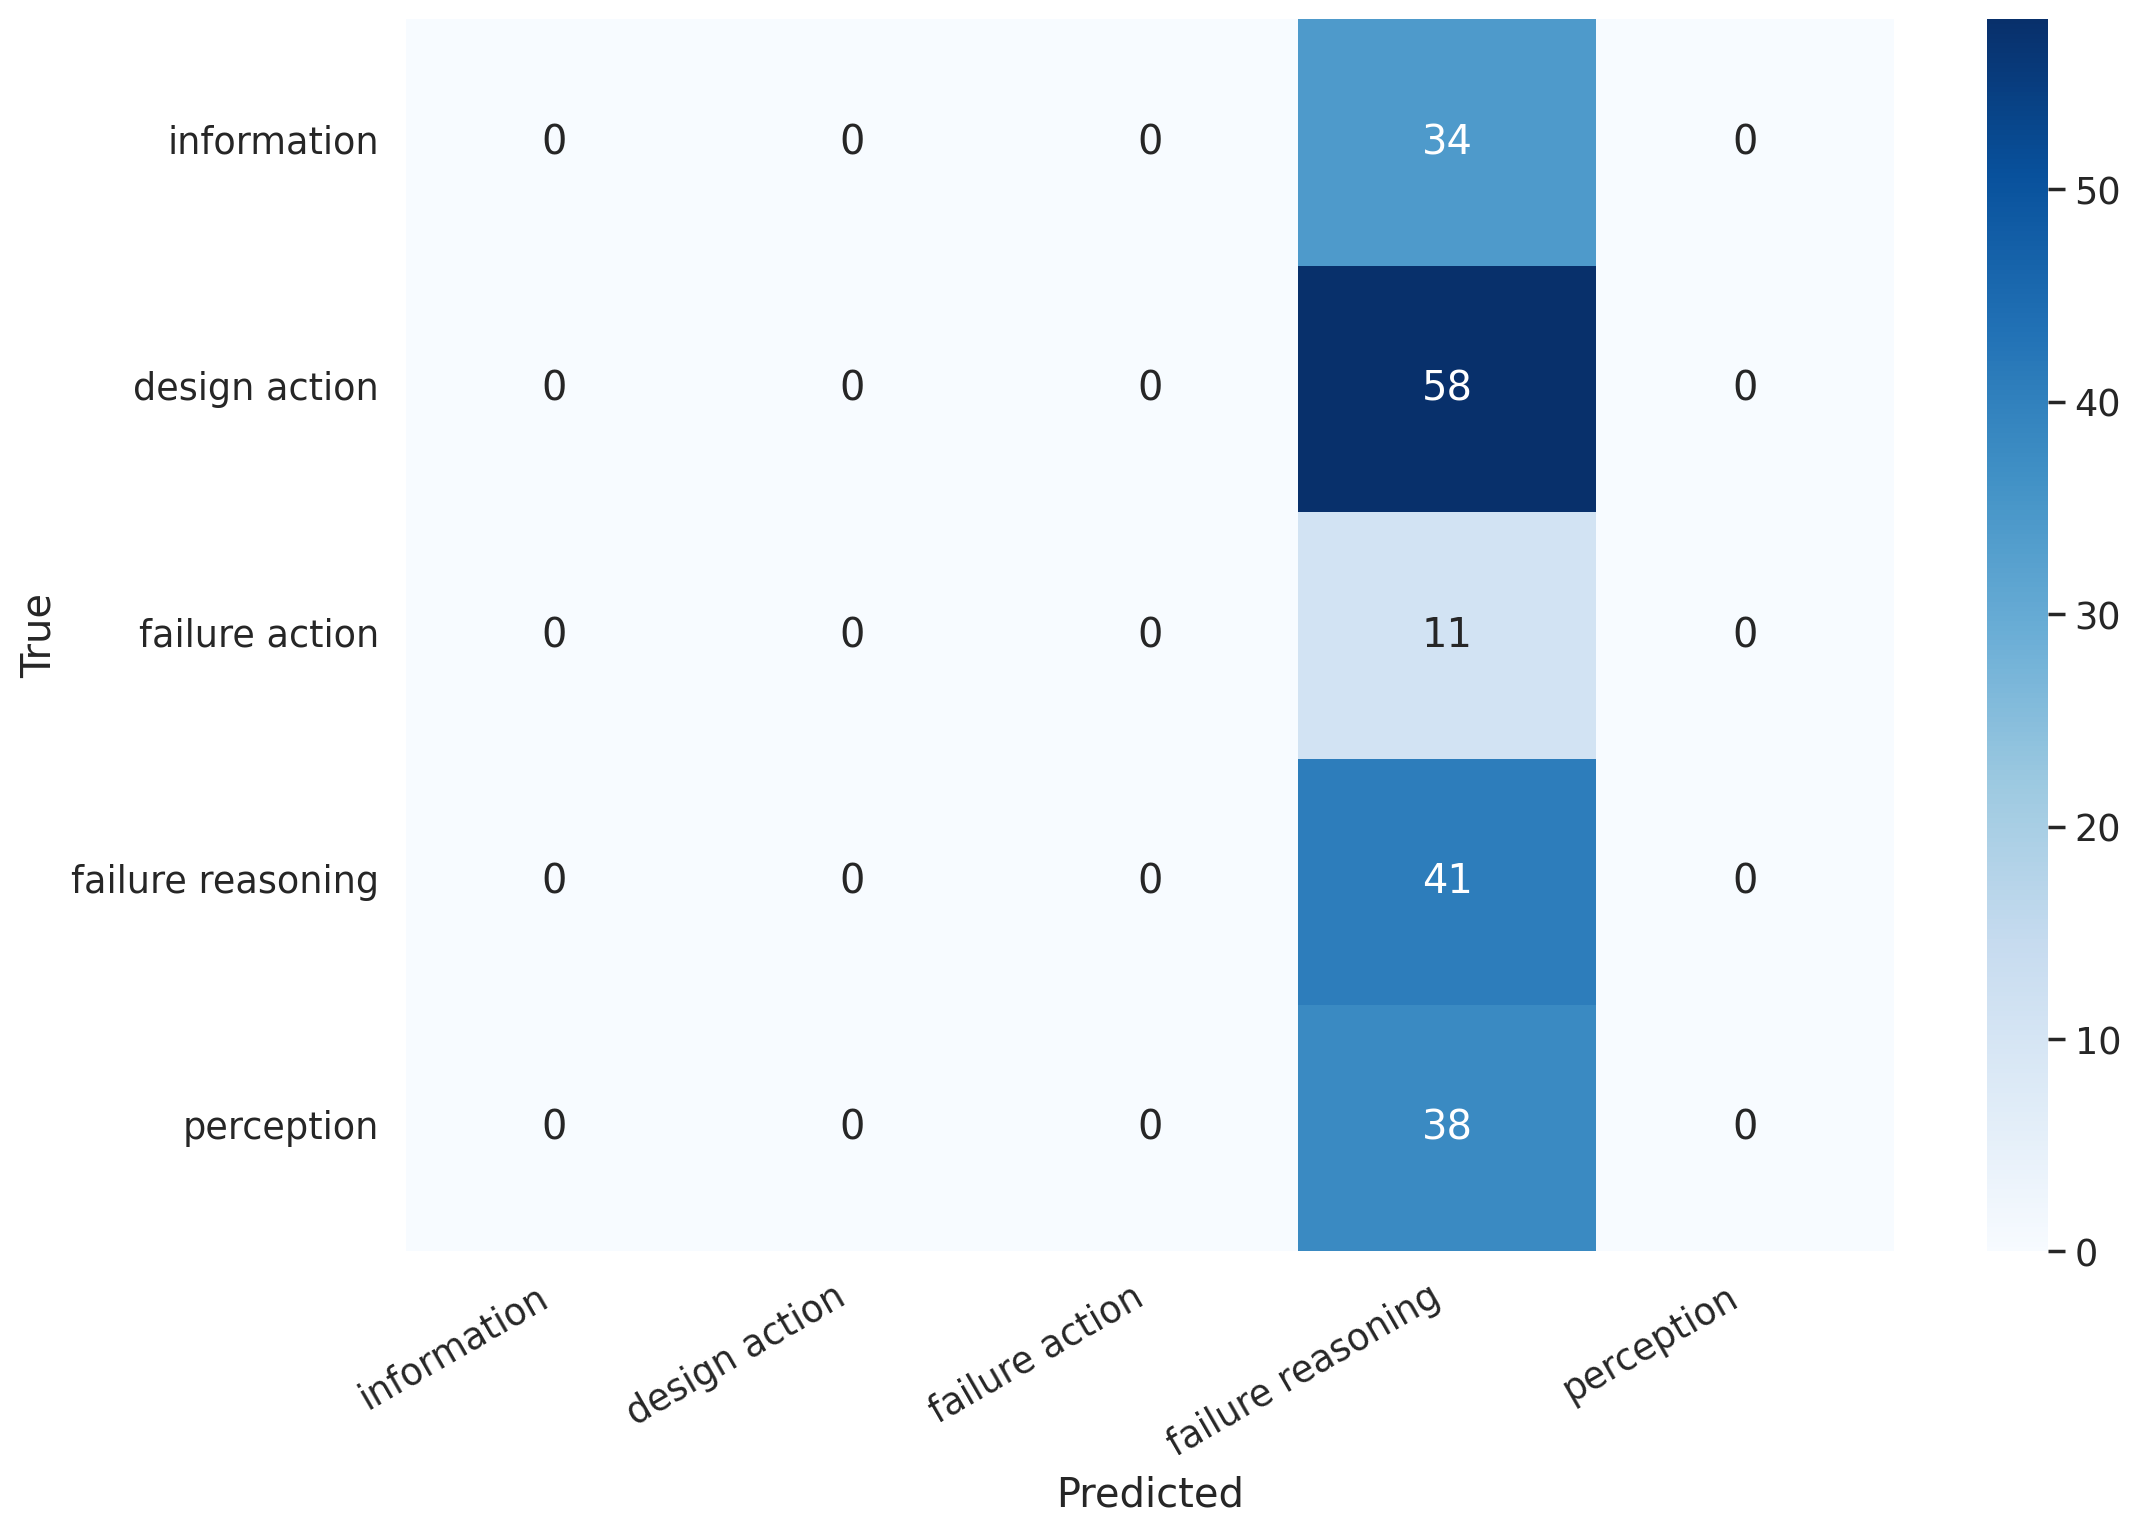

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=P_labels, columns=P_labels)
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(y_test, y_pred, target_names=P_labels))

                   precision    recall  f1-score   support

      information       0.00      0.00      0.00        34
    design action       0.00      0.00      0.00        58
   failure action       0.00      0.00      0.00        11
failure reasoning       0.23      1.00      0.37        41
       perception       0.00      0.00      0.00        38

         accuracy                           0.23       182
        macro avg       0.05      0.20      0.07       182
     weighted avg       0.05      0.23      0.08       182



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
